In [1]:
# Basic set of Python Data Analysis
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.width',180)
pd.set_option('display.max_colwidth', 20)

## for plot by matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
from cycler import cycler
import seaborn as sns

# for plot by matplotlib
sns.set(font="Serif", font_scale=2.0,
        rc={'figure.figsize': (10, 10),
            'lines.markersize': 15,
            "animation.embed_limit": 100})
sns.mpl.rc("axes", prop_cycle
           =cycler('color', ['#E24A33', '#348ABD', '#988ED5',
                             '#777777', '#FBC15E', '#8EBA42',
                             '#FFB5B8']))
sns.set_style('darkgrid', {'axes.facecolor': "0.8"})

# for markers
marker = itertools.cycle(('o', 'v', '^', 'D', '+', 'X', '<', '>'))
colors = itertools.cycle(('#E24A33', '#348ABD', '#988ED5', '#777777',
                          '#FBC15E', '#8EBA42', '#FFB5B8'))


## for machine learning with scikit learn
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

## PCCA+ from pyemma
from pyemma.msm import PCCA
from pyemma.coordinates import tica

## import 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.utils.data as Data
from torch.nn import init
import torch.optim as optim

## don't show warning
import warnings
warnings.filterwarnings('ignore')

# import the Escal Tools
import os, sys
sys.path.append(os.path.expanduser("../../toolkits"))


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
%load_ext autoreload
%autoreload 2
import basicTools as bt
import Etranform as et
from Etranform import Efft as et
from mapTools import encoder as mt
from mapTools import linear as lrm

# Parameters

In [3]:
## the data directory
datadir = os.path.realpath("../../data")
fname = "375"
filePref = f"{datadir}/{fname}"
print("The analysis will do for: \n", filePref)

## set the feature
feature = "dih"  #dih or dist

## The data per frames
skip = 1
imax = 100001

### similar metrix
similar = bt.dist.cosin

### smooth
step    = 100
width   = 200
seg2vec = bt.segment.mean

### evalute method
evalute = bt.evalute.cluster

The analysis will do for: 
 /home/ghzuo/data/gromacs/data.Chignolin/5awl/unfolding/375


# The Input Data

## Structure of Trajectory

In [4]:
## read data from file
X0 = bt.feature.dih2X(f"{filePref}-rama.xvg") if feature == "dih" \
        else bt.feature.dist2X(f"{filePref}-CaDist.xvg") 

## get max length
if imax == 0 or imax>len(X0):
    imax = len(X0) 

## resample the X0
X0 = X0.iloc[1:imax:skip,:].reset_index(drop=True)
X0 = np.array(X0)
print("The shape of X0 is: ", X0.shape)
Xx = (X0 - np.mean(X0, axis=0))/np.std(X0,axis=0)
print("The shape of Xx is: ", Xx.shape)

The shape of input dihedral is:  (800008, 3)
The shape of X0 is:  (100000, 32)
The shape of Xx is:  (100000, 32)


## Energy of Trajectory

In [5]:
## read the energy data
eng = pd.DataFrame(np.loadtxt(f"{filePref}-potential.xvg", comments=["@","#"],
                             dtype = {'names': ('time', 'energy'), 
                                     'formats': ('f', 'f')}))

### output the data info
print("The shape of Raw Energy is: ", eng.shape)
eng = eng.iloc[1:imax:skip]

### base frequence in MHz
## 1000,000 for M and P, and 2 for even extension
ufreq = 500000/eng.loc[len(eng)-1, "time"]
print("The base frequence is {:.4f} MHz".format(ufreq))

E0 = np.array(eng['energy'])
print("The shape of Energy is: ", E0.shape)

The shape of Raw Energy is:  (100001, 2)
The base frequence is 0.5000 MHz
The shape of Energy is:  (100000,)


## RMSD from Native Structure

In [6]:
rms = np.loadtxt(f"{filePref}-CaRMS.xvg", comments=["@","#"],
                 dtype = {'names': ('time', 'rms'), 
                          'formats': ('f', 'f')})
rms = rms[1:imax:skip]
print("The shape of RMS is: ", rms.shape)

The shape of RMS is:  (100000,)


Text(0.5, 0, 'RMSD (nm)')

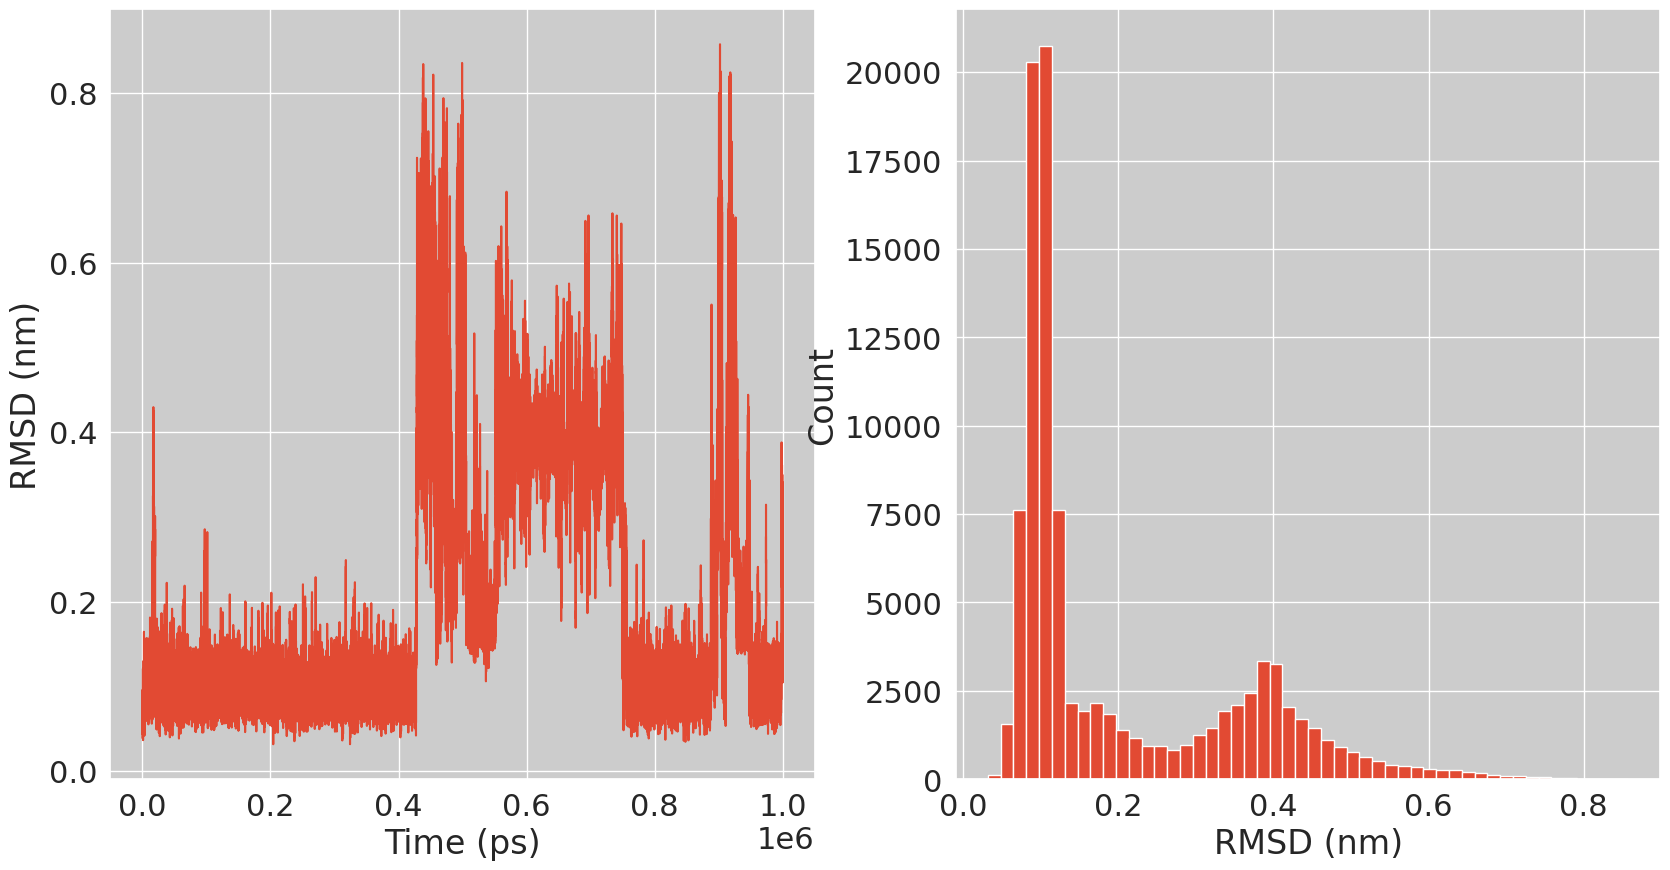

In [7]:
plt.figure(12,figsize=(20,10))
ax = plt.subplot(121)
ax.plot(rms['time'], rms['rms'])
plt.xlabel("Time (ps)")
plt.ylabel("RMSD (nm)")
ax = plt.subplot(122)
hist = ax.hist(rms["rms"], bins=50)
plt.ylabel("Count")
plt.xlabel("RMSD (nm)")

# Build and Pre-Train Network

In [8]:
## do FFT rescaling
efft = et(Xx, E0, base=False)

In [9]:
# set the network
nInput = X0.shape[1]
net = mt.MLP3L(nInput, nHidden=16)
#net = mt.LR(nInput)
#net = nn.Sequential(OrderedDict([('features',nn.Linear(nInput, 1))]))
print(net)

MLP3L(
  (input): Linear(in_features=32, out_features=16, bias=True)
  (actI): ELU(alpha=1.0)
  (hidden): Linear(in_features=16, out_features=16, bias=True)
  (actH): ELU(alpha=1.0)
  (feature): Linear(in_features=16, out_features=16, bias=True)
  (actF): ELU(alpha=1.0)
  (output): Linear(in_features=16, out_features=1, bias=True)
)


In [10]:
## set mapping method
xmap = mt.EncoderNet(net, efft, batch_size=30)

# Score of Kappa

In [11]:
## get the score
xmap.preTrain(n_epochs=5)
qmc = xmap.score(kmax=50, kmin=2, n_epochs=2)

Validate for Score (kappa=8.0): 0.7920115288608176 0.3727177381515503
Validate for Score (kappa=9.0): 0.8085157200117219 0.346302330493927
Validate for Score (kappa=10.0): 0.8211060636488132 0.325784832239151
Validate for Score (kappa=11.0): 0.8552624353510009 0.268526166677475
Validate for Score (kappa=12.0): 0.8476374751529998 0.28151071071624756
Validate for Score (kappa=13.0): 0.8405615821655809 0.29345622658729553
Validate for Score (kappa=14.0): 0.8550320037351059 0.26892027258872986
Validate for Score (kappa=15.0): 0.8473343303817368 0.2820245325565338
Validate for Score (kappa=16.0): 0.8457918186679659 0.2846361994743347
Validate for Score (kappa=17.0): 0.8496663041608518 0.2780671715736389
Validate for Score (kappa=18.0): 0.8671998719028786 0.24796438217163086
Validate for Score (kappa=19.0): 0.8642724504685964 0.2530331313610077
Validate for Score (kappa=20.0): 0.8684889246734607 0.24572698771953583
Validate for Score (kappa=21.0): 0.8674783390787288 0.2474813312292099
Valida

Text(28.7, 0.850519829790044, '#24 (11.5 MHz)\nQMC = 0.89')

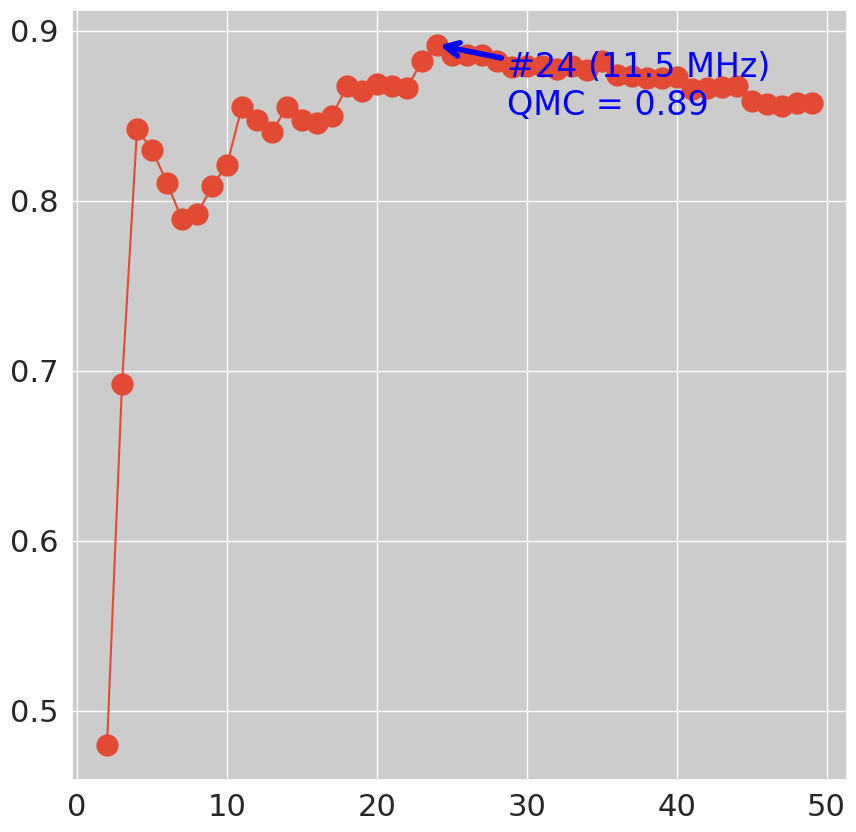

In [12]:
## plot the multiple correlation coefficient
plt.plot(qmc['list'][:,0],qmc['list'][:,1], marker="o")

## annotate the peak value
xy     = (qmc['KappaMax'], qmc['qmcMax'])
offset = 0.1 * (np.max(qmc['list'], axis=0)-np.min(qmc['list'],axis=0))
xytxt  = [xy[0] + offset[0], xy[1] - offset[1]]
plt.annotate("#{:d} ({:.1f} MHz)\nQMC = {:.2f}"
            .format(int(xy[0]), (xy[0]-1)*ufreq, xy[1]), 
            xy=xy, xytext=xytxt, color='blue', 
            arrowprops=dict(arrowstyle="->", color='blue', lw=4))

# Scaling of Selected Kappa

In [13]:
kappa = qmc['KappaMax']
rescl = xmap.scale(kappa, n_epochs=10)

Validate for Scaling (kappa=24.0): 0.8937382660609033 0.20123191177845


## Weight of Features

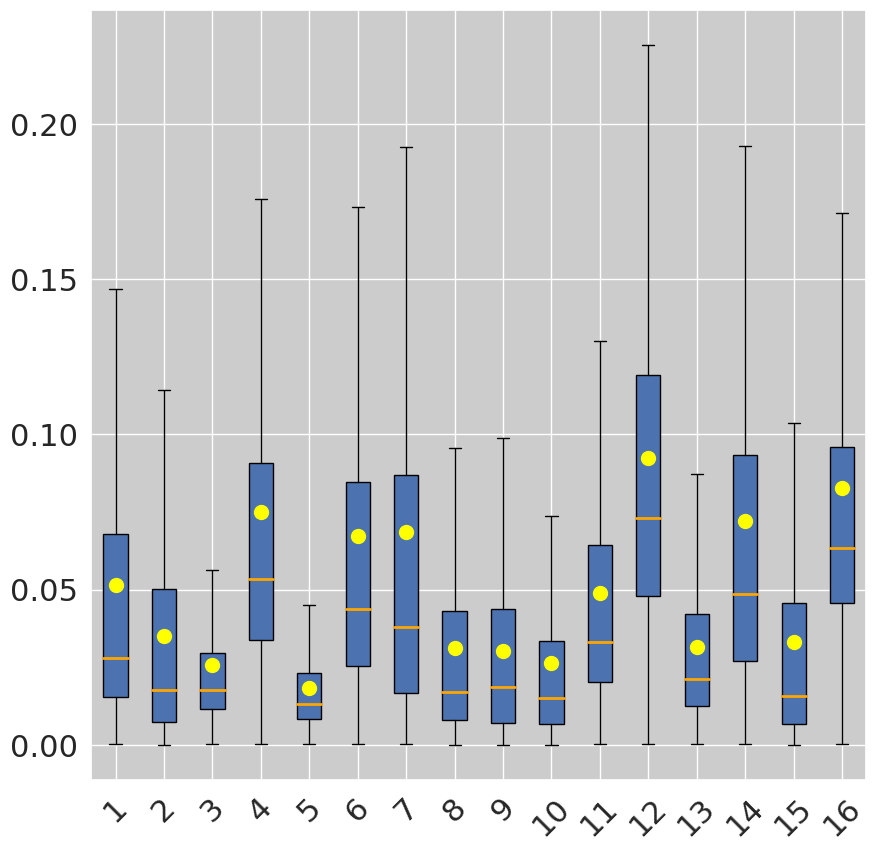

In [14]:
if net.__name__ == "LR":
    bt.plot.coefplot(bt.feature.dihCombind(rescl['A']) if feature == "dih" else rescl['A'])
else:
    sal = xmap.get_saliency()
    if feature == 'dih':
        sal = bt.feature.dihCombind(sal)
    bt.plot.saliplot(sal.T)

## Effective Energy

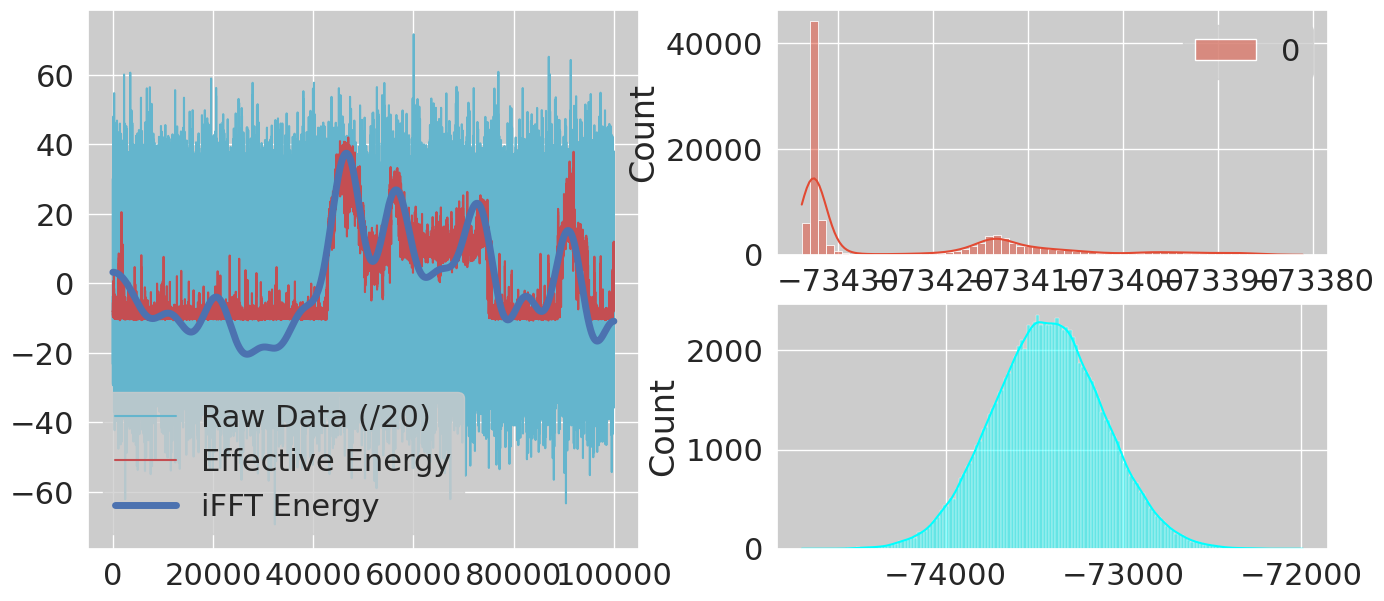

In [15]:
## plot the effective energy
bt.plot.efplot(E0, efft.Ef(kappa), rescl['Ee'])

## Distribution & Free Energy

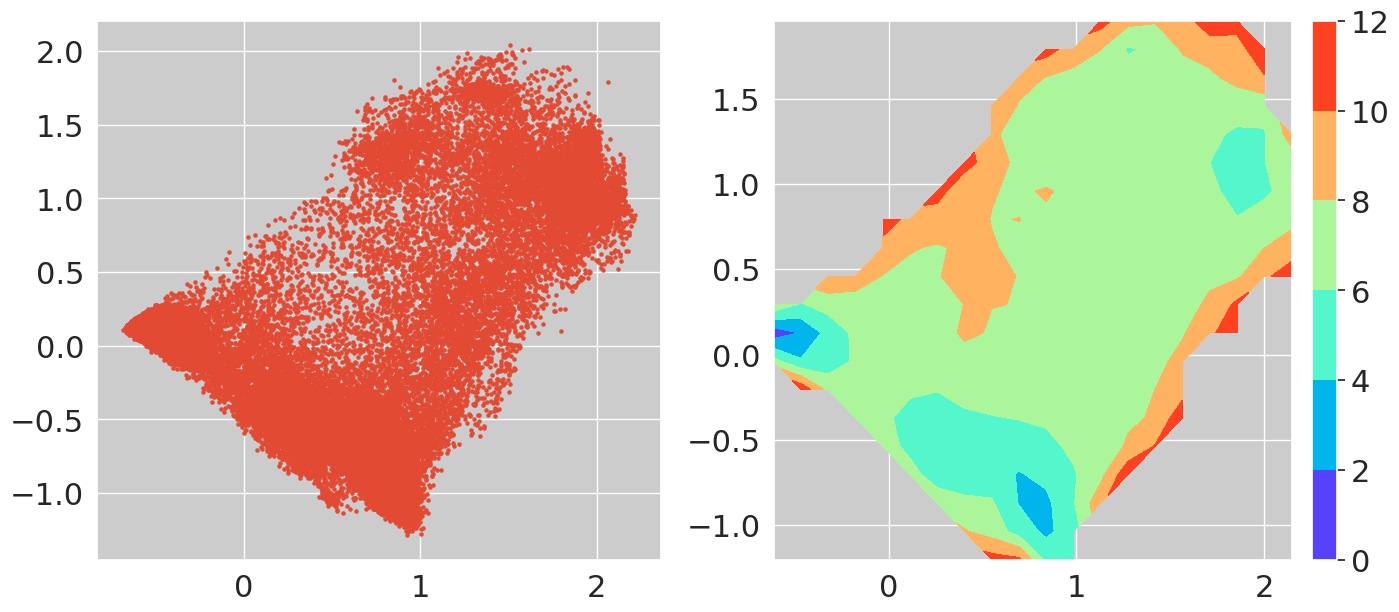

In [16]:
if rescl['X'].shape[1] == 2:
    bt.plot.distr_plot(rescl['X'])
else:
    ## plot by PCA eigen vector
    pca = PCA(n_components = 2)
    bt.plot.distr_plot(pca.fit_transform(rescl['X']))

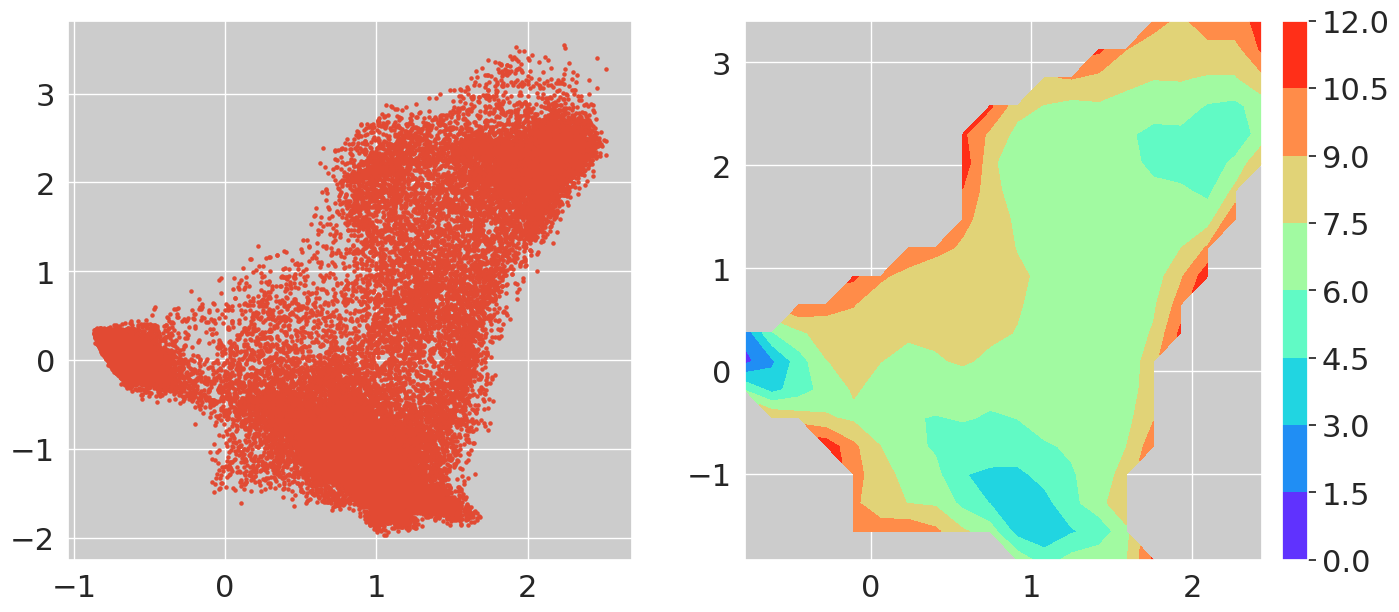

In [17]:
## plot by TICA eigen vector
bt.plot.distr_plot(tica(rescl['X'],dim=2,lag=50).get_output()[0])

# Matrix Analysis

## Sample Data

In [18]:
## get the samples
X0s = seg2vec(Xx, step, width)
Xys = seg2vec(rescl['X'], step, width)

## Testing Similarity Matrix

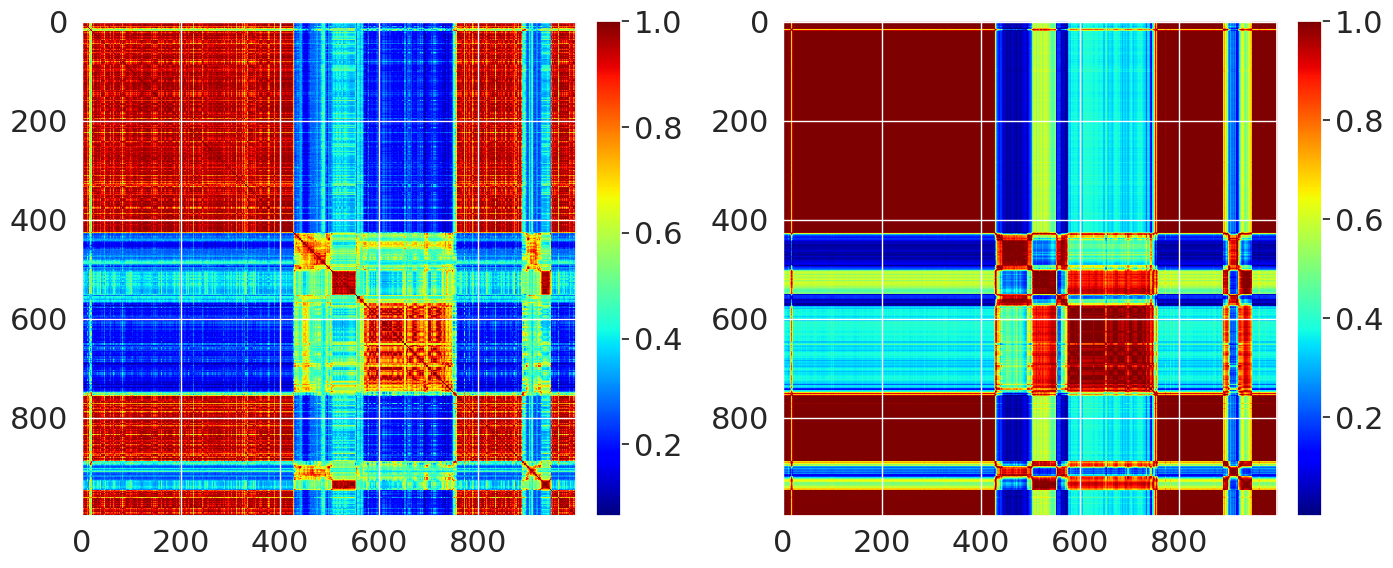

In [19]:
## set distance function and get distance
Smat0  = similar(X0s)
Smaty  = similar(Xys)
    
### plot
fig, axs = plt.subplots(1,2, figsize=(16,32)) 
fig.subplots_adjust(wspace=0.3)
bt.plot.implot(Smat0, axs[0])
bt.plot.implot(Smaty, axs[1])

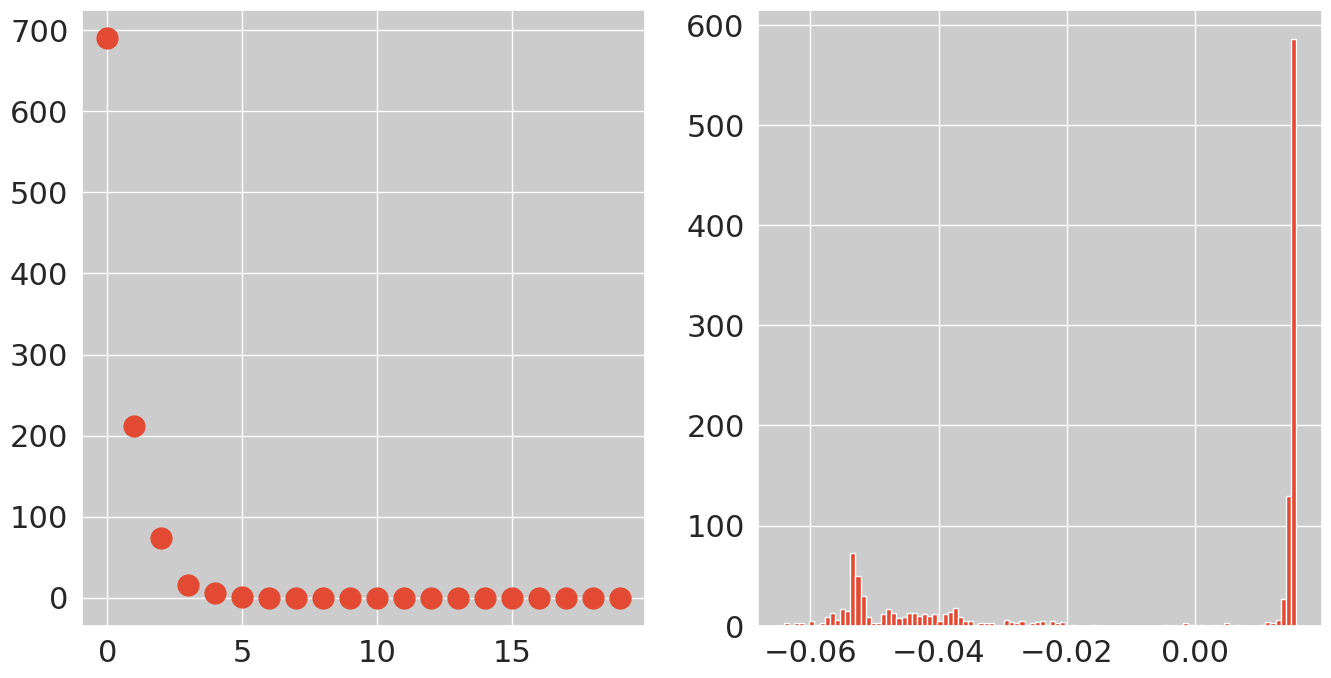

In [20]:
w,v = np.linalg.eig(Smaty)

fig, axs = plt.subplots(1,2, figsize=(16,8)) 
axs[0].plot(w[0:20], "o")
hist = axs[1].hist(v[:,1], bins=100, density=True)

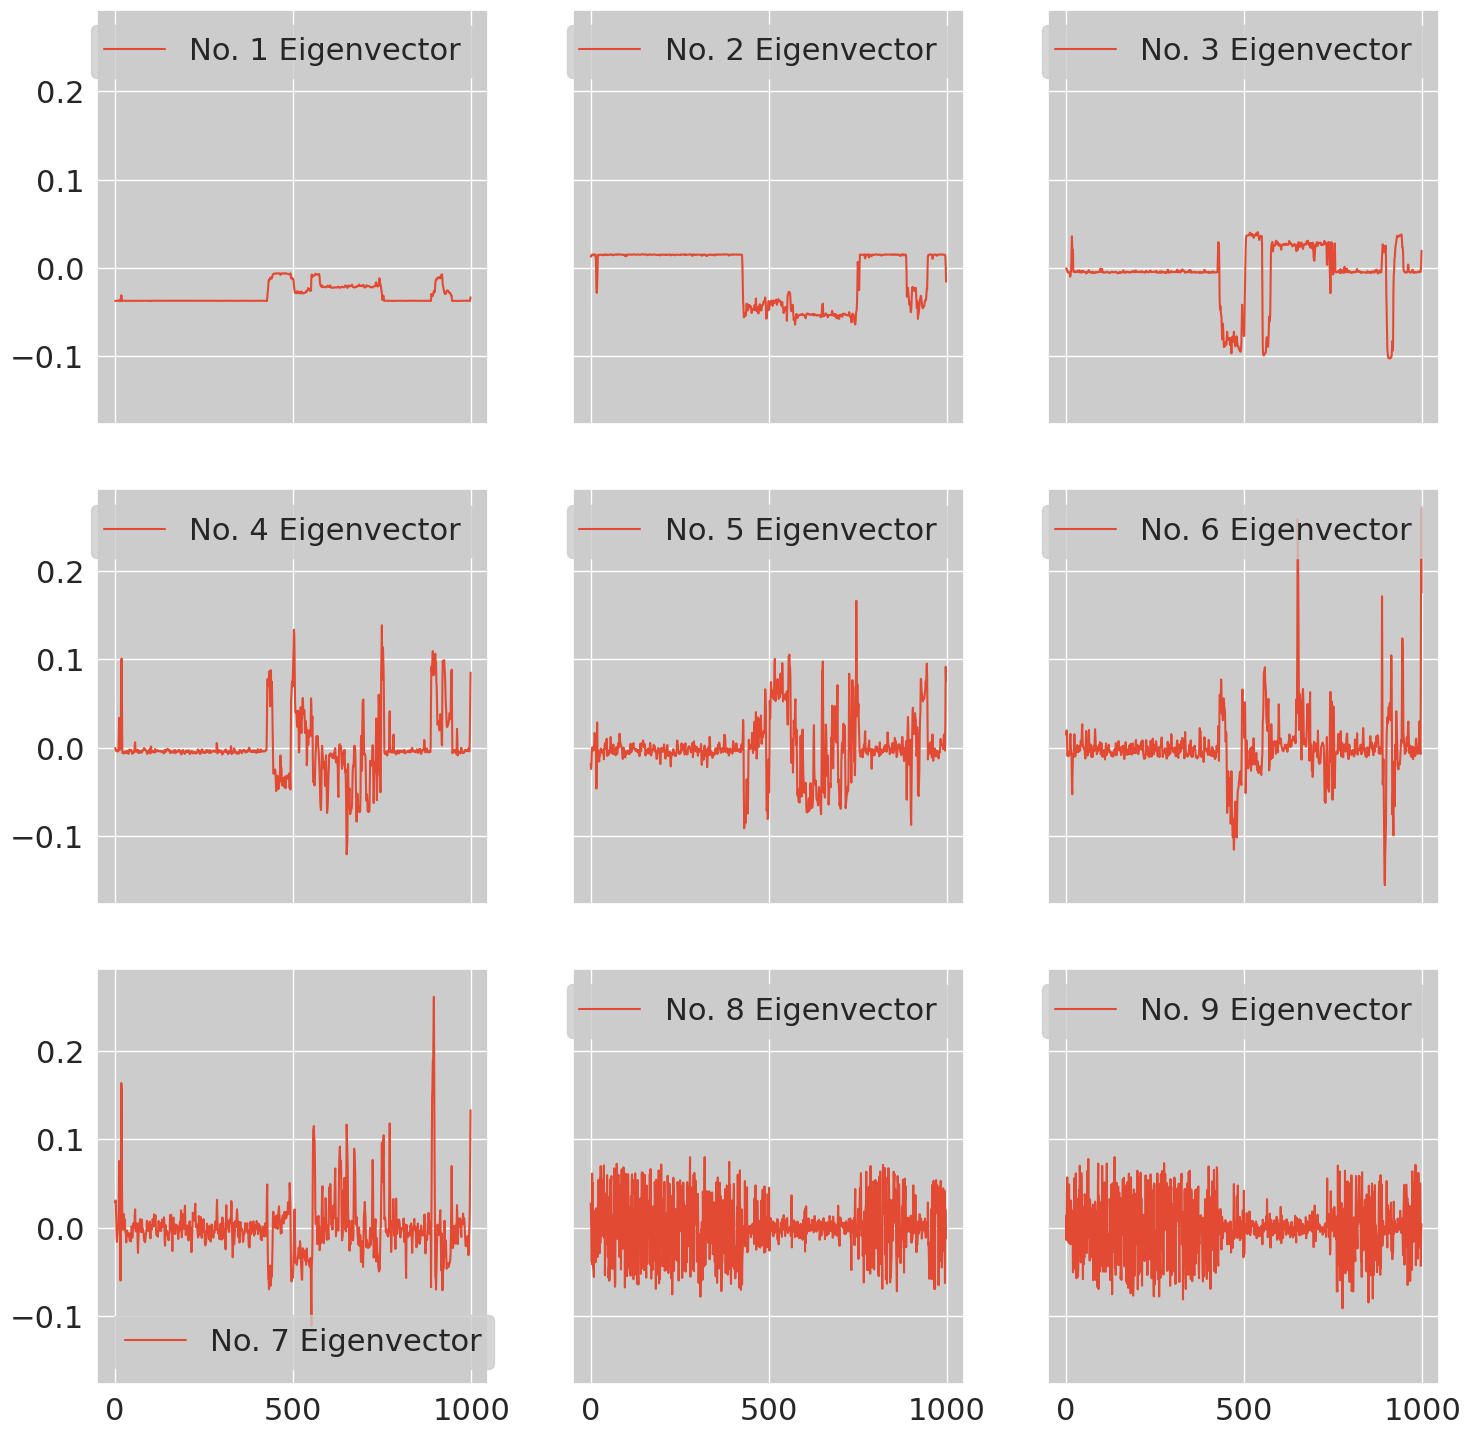

In [21]:
fig, axs = plt.subplots(3,3,sharex=True,sharey=True, figsize=(15,15)) 
sel = range(0,np.size(axs))
fig.tight_layout()
for ax, key in zip(axs.reshape(len(sel)), sel): 
    ax.plot(v[:,key])
    ax.legend(labels =["No. " + str(key+1) + " Eigenvector"])

# Clustering

In [22]:
outcl = {}

## Clustering by Kmeans

In [23]:
## Test KMean parameters
def testKMn(n):
    cl = KMeans(n_clusters=n,n_init=50).fit_predict(Xys)
    return evalute(Xys, cl)

score_KMean = pd.DataFrame({'ncluster':np.arange(2,10)})
score_KMean['score'] = score_KMean['ncluster'].apply(testKMn)

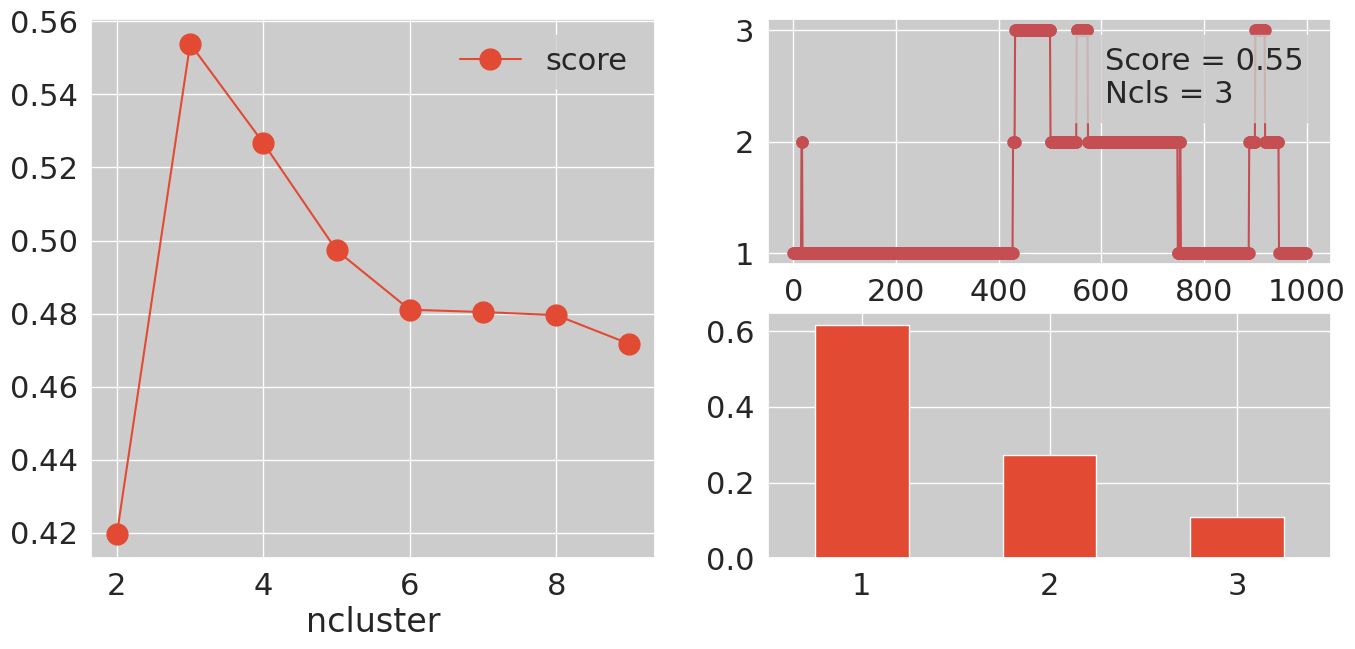

In [24]:
idxPeak = score_KMean['score'].idxmax();
ncls = score_KMean.loc[idxPeak,'ncluster']
cl = KMeans(n_clusters=ncls,n_init=50).fit_predict(Xys)
score = evalute(Xys, cl)

## get the best cluster
outcl['Kmeans'] = {'score':score, 'cl':cl}

## plot data
lab = "Score = {:.2f}\nNcls = {:d}".format(score, ncls)
bt.plot.clplot(score_KMean.set_index('ncluster'), cl, lab)



## Clustering by KMediods

In [25]:
## Testing Kmediods parameters by trajectory
def testKMs(n):
    cl = KMedoids(n_clusters=n).fit_predict(Xys)
    return evalute(Xys, cl)

score_KMedoids = pd.DataFrame({'ncluster':np.arange(2,10)})
score_KMedoids['score'] = score_KMedoids['ncluster'].apply(testKMs)

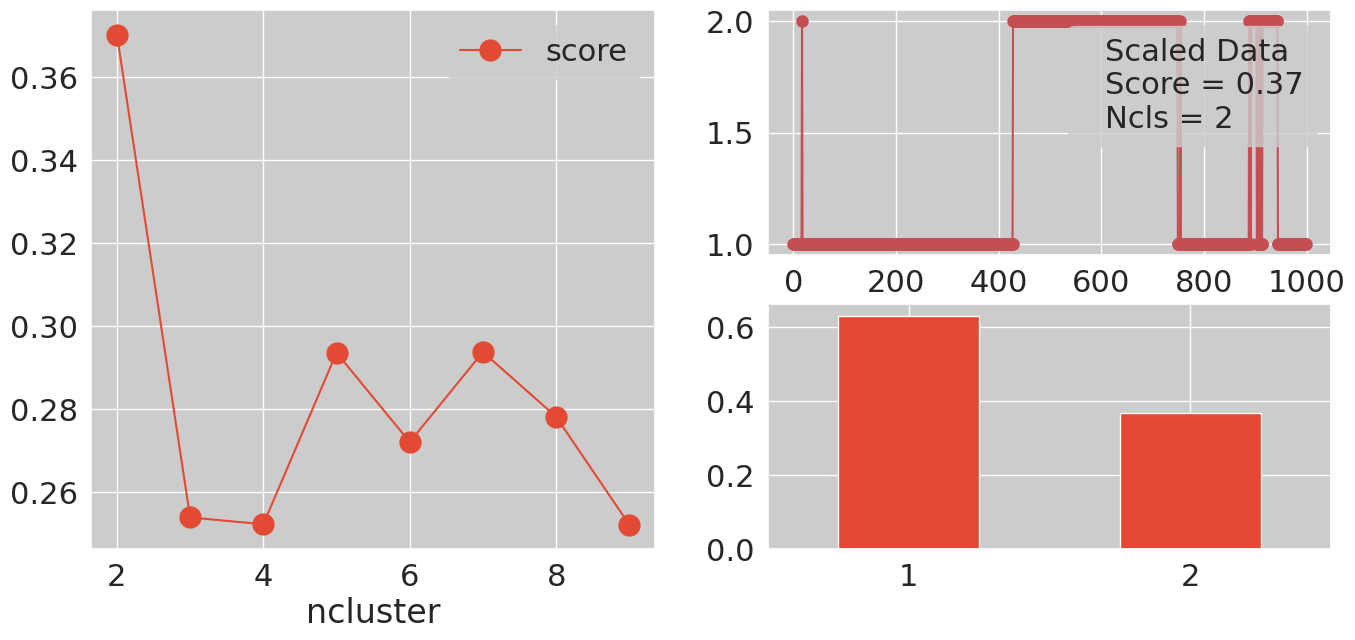

In [26]:
idxPeak = score_KMedoids['score'].idxmax();
ncls = score_KMedoids.loc[idxPeak,'ncluster']
cl = KMedoids(n_clusters=ncls).fit_predict(Xys)
score = evalute(Xys, cl)

## get the best cluster
outcl['GMM'] = {'score':score, 'cl':cl}

### plot data
lab = "Scaled Data\nScore = {:.2f}\nNcls = {:d}".format(score, ncls)
bt.plot.clplot(score_KMedoids.set_index('ncluster'), cl, lab)

## Clustering by GMM

In [27]:
# Test KMean parameters
def testGMM(n):
    cl = GaussianMixture(n_components=n,n_init=50).fit_predict(Xys)
    return evalute(Xys, cl)

score_GMM = pd.DataFrame({'ncluster':np.arange(2,10)})
score_GMM['score'] = score_GMM['ncluster'].apply(testGMM)

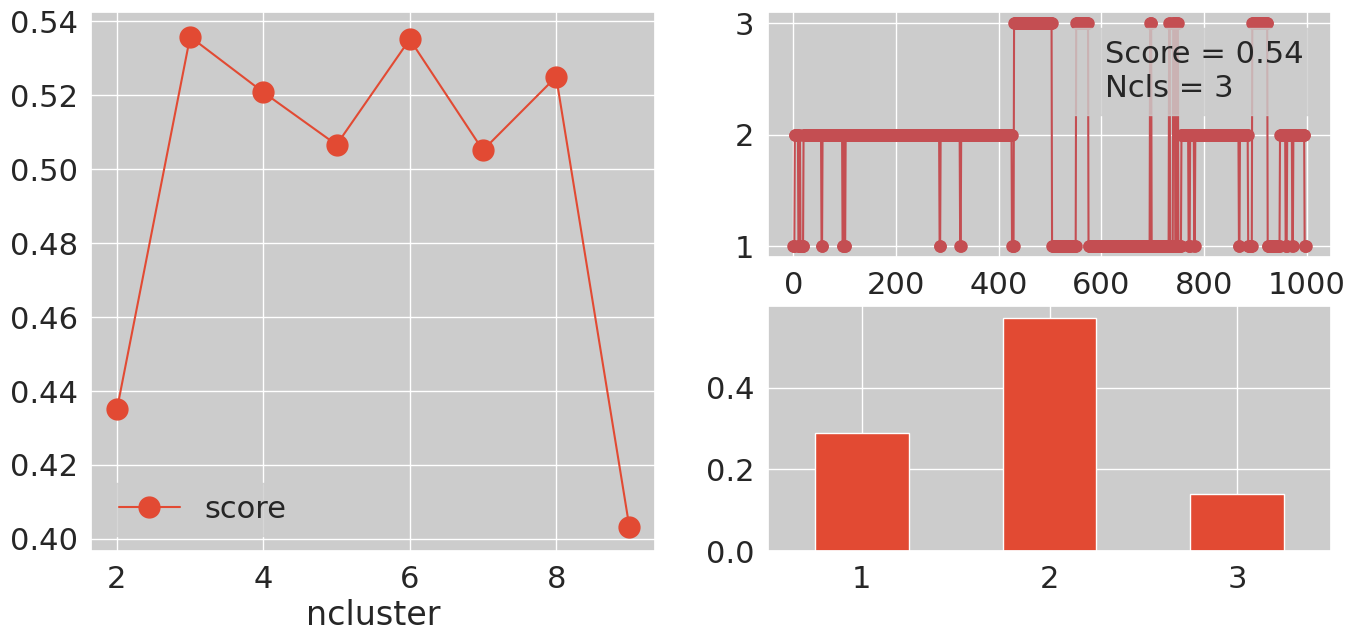

In [28]:
### find the top score parameter
idxPeak = score_GMM['score'].idxmax();
ncls = score_GMM.loc[idxPeak,'ncluster']
cl = GaussianMixture(n_components=ncls, n_init=50).fit_predict(Xys)
score = evalute(Xys, cl)

## get the best cluster
outcl['GMM'] = {'score':score, 'cl':cl}

### plot data
lab = "Score = {:.2f}\nNcls = {:d}".format(score, ncls)
bt.plot.clplot(score_GMM.set_index('ncluster'), cl, lab)

## Clustering by Spectral Clustering with Trajectory

In [29]:
score_Spectral = pd.DataFrame(columns=["gamma", "ncls", "score"])
for gamma in [0.05, 0.1, 0.5, 1]:
    for ncls in np.arange(2,10):
        cl = SpectralClustering(n_clusters=ncls, gamma=gamma).fit_predict(Xys)
        score_Spectral.loc[len(score_Spectral.index)] = [gamma, ncls, evalute(Xys, cl)]

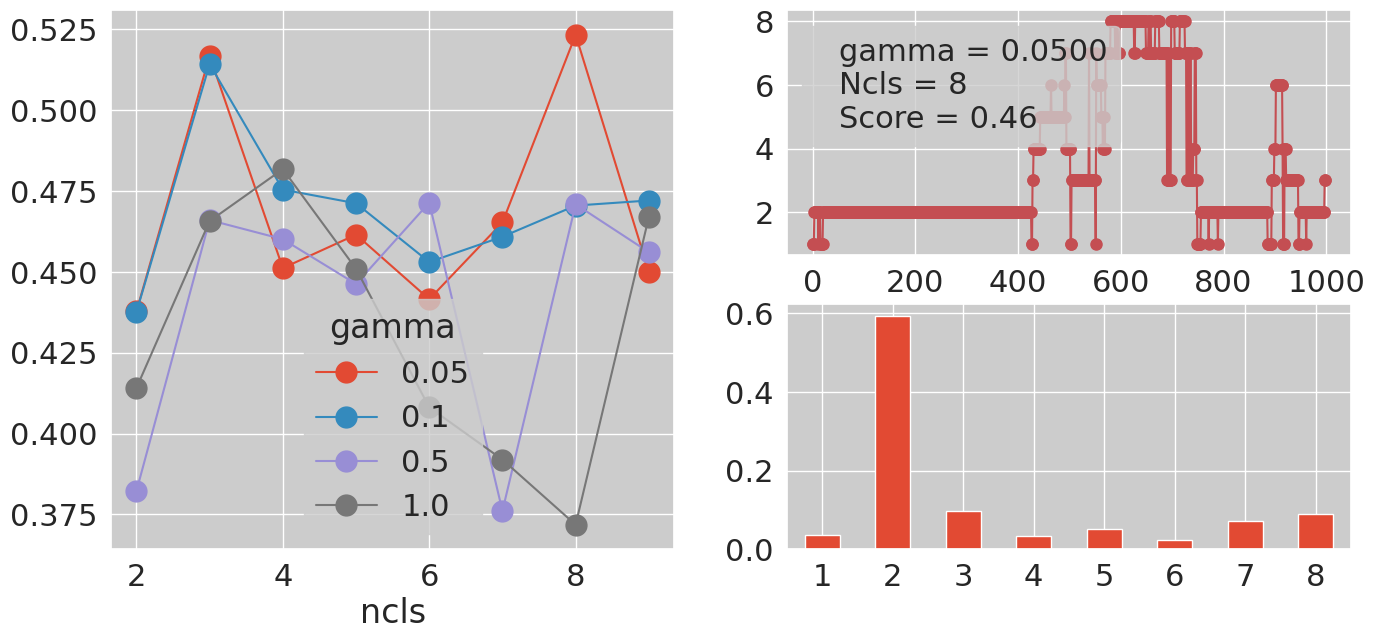

In [30]:
idxPeak = score_Spectral['score'].idxmax();
gamma   = score_Spectral.loc[idxPeak,"gamma"]
ncls    = score_Spectral.loc[idxPeak, "ncls"].astype(int)
cl  = SpectralClustering(n_clusters=ncls, gamma=gamma).fit_predict(Xys)
score = evalute(Xys, cl)

## get the best cluster
outcl['SpecTraj'] = {'score':score, 'cl':cl}

### plot data
lab = "gamma = {:.4f}\nNcls = {:d}\nScore = {:.2f}".format(gamma, ncls, score)
bt.plot.clplot(score_Spectral.pivot(index='ncls', columns="gamma", values="score"), cl, lab)

## Clustering by Spectral Clustering with Matrix

In [31]:
## Testing Spectral Clustering by matrix
def testSC(n):
    cl = SpectralClustering(n_clusters=n, affinity='precomputed').fit_predict(Smaty)
    return evalute(Xys, cl)

### get the score
score_SpectralMat = pd.DataFrame({'ncluster':np.arange(2,10)})
score_SpectralMat['score'] = score_SpectralMat['ncluster'].apply(testSC)

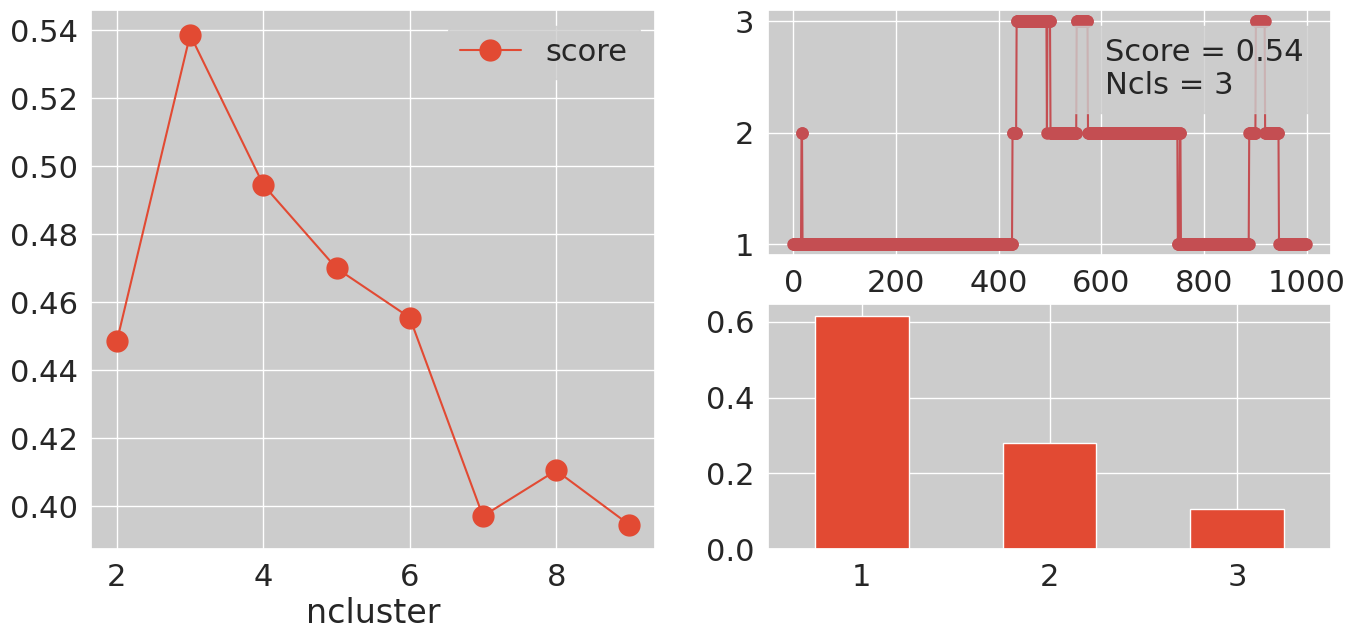

In [32]:
### find the top score parameter
idxPeak = score_SpectralMat['score'].idxmax();
ncls = score_SpectralMat.loc[idxPeak,'ncluster']
cl = SpectralClustering(n_clusters=ncls, affinity='precomputed').fit_predict(Smaty)
score = evalute(Xys, cl)

## get the best cluster
outcl['SpecMatrix'] = {'score':score, 'cl':cl}

### plot data
lab = "Score = {:.2f}\nNcls = {:d}".format(score, ncls)
bt.plot.clplot(score_SpectralMat.set_index('ncluster'), cl, lab)

## Clustering by DBSCAN

In [33]:
## Testing DBSCAN parameters
score_DBSCAN = pd.DataFrame(columns=["cutoff", "Min Samples", "score"])
for f in np.arange(0.2, 0.6, 0.1)*np.linalg.norm(np.std(Xys, axis=0)):
    for n in np.arange(5,15):
        cl = DBSCAN(eps=f, min_samples=n).fit_predict(Xys)
        score_DBSCAN.loc[len(score_DBSCAN.index)] = [f, n, evalute(Xys, cl)]     

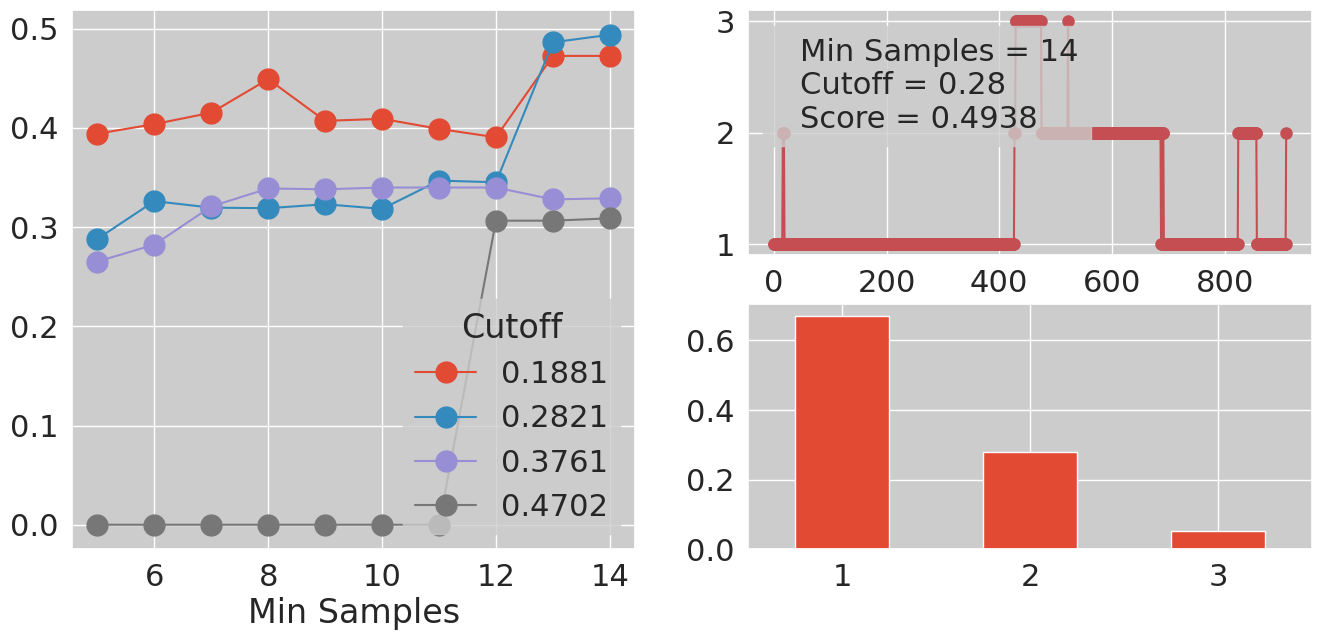

In [34]:
### the opt parameter
idxPeak = score_DBSCAN['score'].idxmax();
f  = score_DBSCAN.loc[idxPeak,"cutoff"]
n  = score_DBSCAN.loc[idxPeak, "Min Samples"].astype(int)
cl = DBSCAN(eps=f, min_samples=n).fit_predict(Xys)
score = evalute(Xys, cl)

## get the best cluster
cl  = cl[cl != -1]
outcl['DBSCAN'] = {'score':score, 'cl':cl}

#### plot data
lab = "Min Samples = {:d}\nCutoff = {:.2f}\nScore = {:.4f}".format(n, f,score)
score_DBSCAN['Cutoff'] = score_DBSCAN['cutoff'].map(lambda x:('%.4f')%x)
bt.plot.clplot(score_DBSCAN.pivot(index='Min Samples', columns="Cutoff", values="score"), cl, lab)

## Clustering by PCCA+

In [35]:
## get Transition matrix
Tmat = bt.dist.expm(Xys)
Tmat = np.array(Tmat/Tmat.sum(axis=1))

In [36]:
### Testing PCCA paraters
def testPCCA(n):
    cl = PCCA(Tmat, n)
    return evalute(Xys, cl.metastable_assignment)

### get the score
score_PCCA = pd.DataFrame({'ncluster':np.arange(2,10)})
score_PCCA['score'] = score_PCCA['ncluster'].apply(testPCCA)

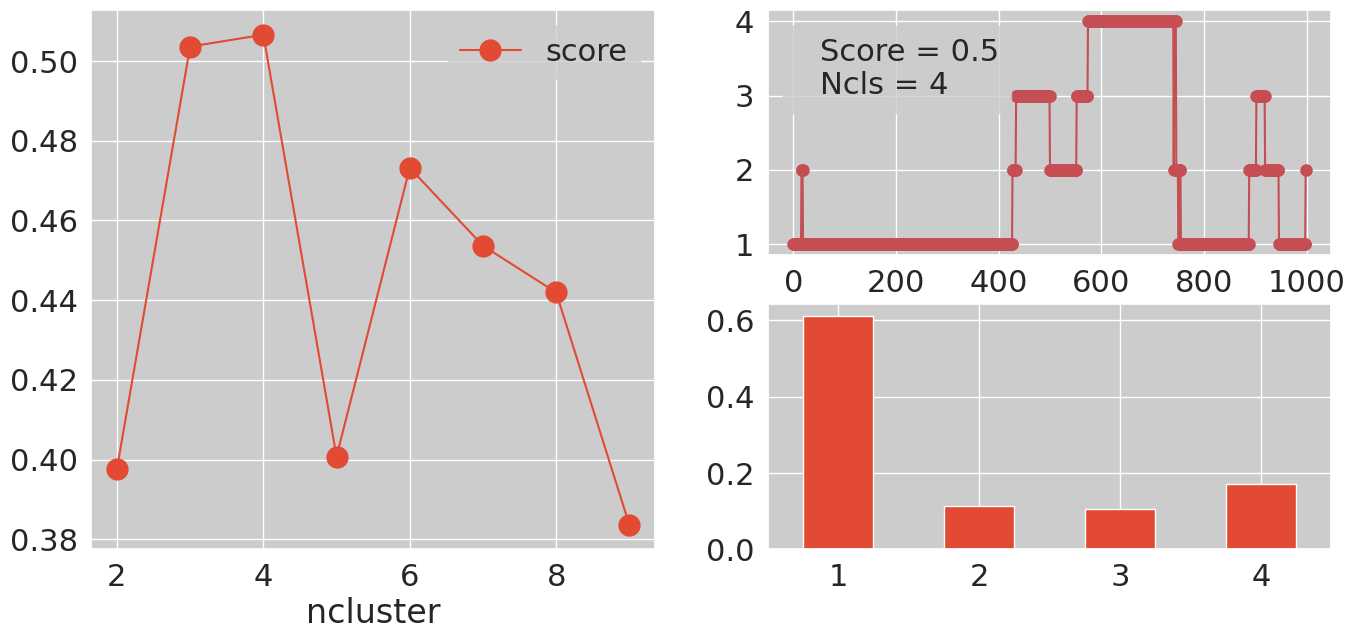

In [37]:
### find the top score parameter
idxPeak = score_PCCA ['score'].idxmax();
ncls = score_PCCA.loc[idxPeak,'ncluster']
cl = PCCA(Tmat, ncls)
score = evalute(Xys, cl.metastable_assignment)

## get the best cluster
outcl['PCCA+'] = {'score':score, 'cl':cl.metastable_assignment}

### plot data
lab = "Score = {:.1f}\nNcls = {:d}".format(score, cl.n_metastable)
bt.plot.clplot(score_PCCA.set_index("ncluster"), cl.metastable_assignment, lab)

# Save Data

In [38]:
## save current ipynb
from ipylab import JupyterFrontEnd
app = JupyterFrontEnd()
app.commands.execute('docmanager:save')

In [39]:
## record output to pdf
#nbname = os.path.basename(app.sessions.get_state().get('current_session').get('path'))
nbname = 'EscalNet-soloTraj.ipynb'
srcpath = %pwd
srcfile = f"{srcpath}/{nbname}"
outfile = f"EscalNet-{net.__name__}-{fname}-{feature}.pdf"

!jupyter nbconvert --to pdf --no-input --log-level 40 \
    --output-dir {datadir} --output {outfile} {srcfile}

# Ploting

In [51]:
import outplot as op
op.basicSet()

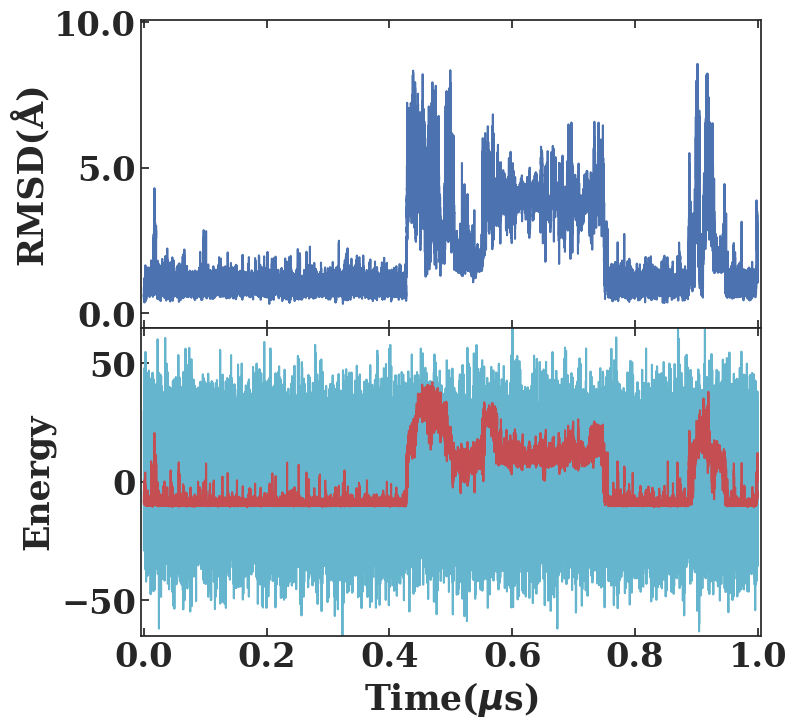

In [49]:
## plot trajectory
fig, ax = plt.subplots(2,1,figsize=(8,8),squeeze=True)
fig.subplots_adjust(hspace=0)
op.trajPlot(ax, rms, E0, rescl['Ee'])

# save figure
trajfile = f"{datadir}/EscalNet-OneTraj-{fname}.pdf"
plt.savefig(trajfile,bbox_inches='tight')

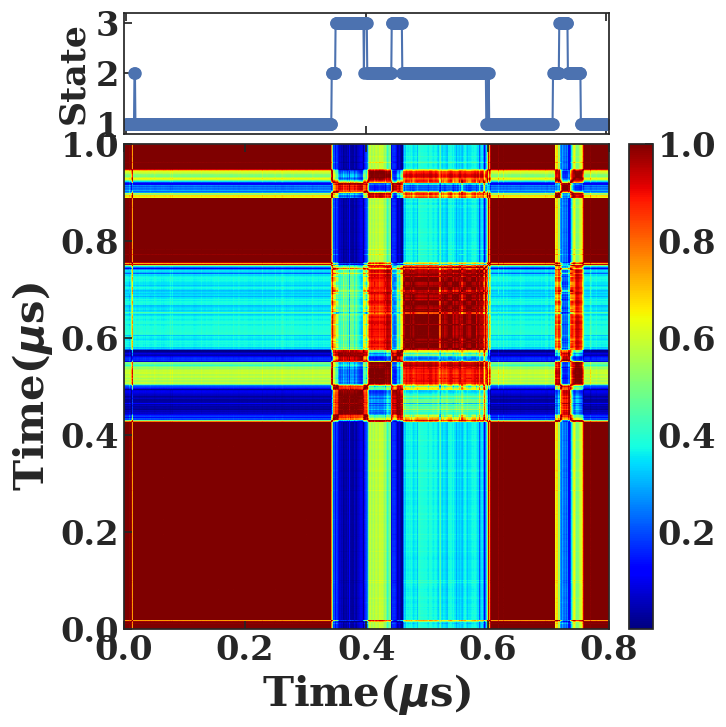

In [50]:
# plot similarity
fig = plt.figure(figsize=(8,8))
ax = plt.subplot()
op.stateplot(ax, Smaty,outcl['SpecMatrix']['cl'])

# save figure
simfile = f"{datadir}/EscalNet-Similar-{fname}.pdf"
plt.savefig(simfile,bbox_inches='tight')

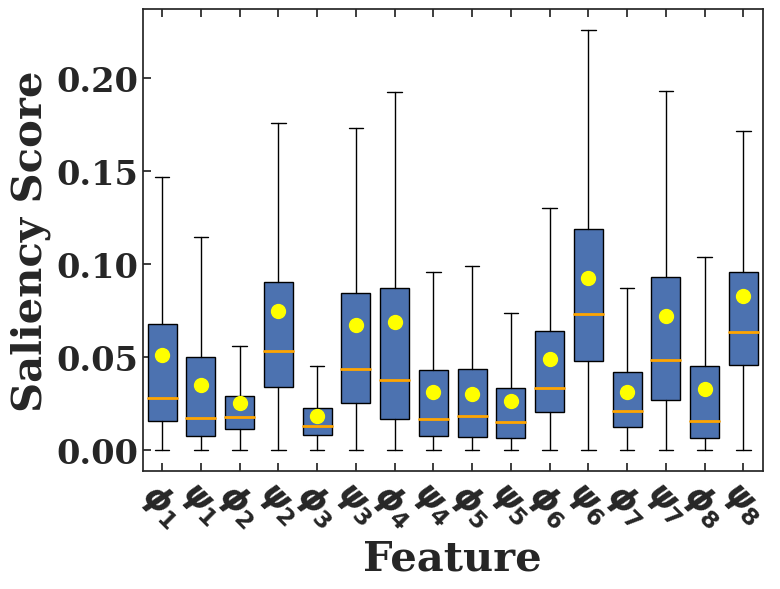

In [52]:
# saliency plot
fig = plt.figure(figsize=(8,6))
ax = plt.subplot()
op.dihSaliPlot(ax, sal)

# save figure
salifile = f"{datadir}/EscalNet-Saliency-{fname}.pdf"
plt.savefig(salifile,bbox_inches='tight')

In [44]:
## do FFT rescaling
efftlr = et(Xx, E0)
## set the mapping tool
xmaplr = lrm.LinearRegress(efftlr, info=0)
## get the score
qmclr = xmaplr.score(kmax=50, kmin=2)

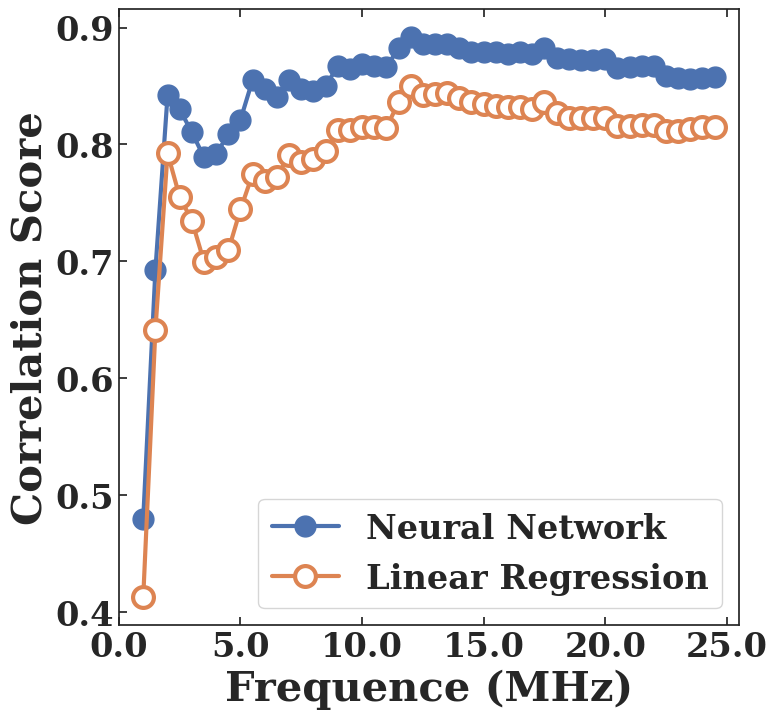

In [45]:
## plot the multiple correlation coefficient
ax = plt.figure(figsize=(8,8))
ax = plt.subplot()
ax.set_facecolor('white')
ax.plot(qmc['list'][:,0],qmc['list'][:,1], marker="o", lw=3,label="Neural Network")
ax.plot(qmclr['list'][:,0],qmclr['list'][:,1], marker="o", lw=3, mew=3, mfc = 'w', label="Linear Regression")
ax.set_xlabel("Frequence (MHz)", fontsize=30, weight="bold")
ax.set_xlim(0,51)
ax.set_xticklabels([0.0, 5.0, 10.0, 15.0, 20.0, 25.0])
ax.set_ylabel("Correlation Score", fontsize=30, weight="bold")
ax.legend()

# save figure
qmcfile = f"{datadir}/EscalNet-Qmc-{fname}.pdf"
plt.savefig(qmcfile,bbox_inches='tight')